# Malicious URL Detection

A URL consists of the top-level domain, hostname, paths, and port of the web
address, as in the following diagram:

In [ ]:
!pip install tld
!pip install pyquery
!pip install python-whois
!pip install shodan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.2/412.2 KB 6.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 KB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for python-whois: filename=python_whois-0.8.0-py3-none-any.whl size=103262 sha256=b11654b9381fc3bda30958c49418c7e0ac6361853f8f3b36029e09b0fa7b9d3d
  Stored in directory: /root/.cache/pip/wheels/24/20/6b/5550a3d6bef09ddaed74eb84006fc3d53f94867f1916794df4
Successfully built python-whois
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 KB 4.9 MB/s eta 0:00:00
  Preparing metadat

<a id="1"></a> <br>
## Importing Libraries

In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from re import compile
from urllib.parse import urlparse
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from socket import gethostbyname
from requests import get
from json import dump
from pyquery import PyQuery
from requests import get
from socket import gethostbyname
from numpy import array, log
from string import punctuation
from json import dump, loads
from tld import get_tld, is_tld
from whois import whois
from shodan import Shodan
from datetime import datetime

<a id="2"></a> <br>
## Load Dataset

In [3]:
data = pd.read_csv('/content/malicious_phish.csv')
data.head()

FileNotFoundError: ignored

<a id="3"></a> <br>
## Meta information of Dataframe

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004 entries, 0 to 1003
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     1004 non-null   object
 1   type    1004 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


<a id="4"></a>
# Checking for NaN values

In [ ]:
data.isnull().sum()

url     0
type    0
dtype: int64

In [ ]:
count = data.type.value_counts()
count

benign        737
defacement    182
phishing       54
malware        31
Name: type, dtype: int64

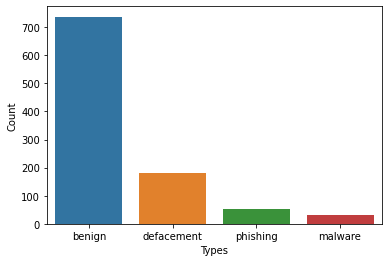

In [ ]:
sns.barplot(x=count.index, y=count)
plt.xlabel('Types')
plt.ylabel('Count');

#### Omitting the (www.) from the URL which is in fact a sub domain in itself.

In [ ]:
data['url'] = data['url'].replace('www.', '', regex=True)
data

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
999,brokenbells.com/,benign
1000,missouri.scout.com/2/1091275.html,benign
1001,amazon.com/Inter-Municipal-Cooperation-Europe-...,benign
1002,amazon.com/Best-Mississippi-John-Hurt/dp/B0000...,benign


In [ ]:
rem = {"Category": {"benign": 0, "defacement": 1, "phishing":2, "malware":3}}
data['Category'] = data['type']
data = data.replace(rem)

In [ ]:
data.head()

,url,type,Category
0,br-icloud.com.br,phishing,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1


<a id="5"></a> <br>
# Feature Extraction

## Lexical Features



In [ ]:
#Methods for features

#Extracting Length of URL
def get_url_path_length(url):
   return len(str(urlparse(url).path))

#Extracting Length of HostName
def get_host_length(url):
   return len(str(urlparse(url).netloc))

#Extracting Host IP information
def get_url_host_is_ip(url):
    host = urlparse(url).netloc
    pattern = compile("^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$")
    match = pattern.match(host)
    return match is not None   

#Extracting Host Port information
def get_url_has_port_in_string(url):
    has_port = urlparse(url).netloc.split(':')
    return len(has_port) > 1 and has_port[-1].isdigit()

#Extracting number of fragments
def get_number_of_fragments(url):
    frags = urlparse(url).fragment
    return len(frags.split('#')) - 1 if frags == '' else 0   

#Extracting number of subdirectories
def get_number_of_subdirectories(url):
    d = urlparse(url).path.split('/')
    return len(d)     

#Extracting encoding information
def get_is_encoded(url):
    return '%' in url.lower()

#Extracting top level domain
def process_tld(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain    

#Extracting number of digits
def get_number_of_digits(url):
    digits = [i for i in url if i.isdigit()]
    return len(digits)

#Extracting number of parameters
def get_number_of_parameters(url):
    params = urlparse(url).query
    return 0 if params == '' else len(params.split('&'))  

#Extracting admin information
def has_admin_in_string(url):
    return 'admin' in url.lower()      

In [ ]:
data['domain'] = data['url'].apply(lambda i: process_tld(i))

data['url_path_length']=data['url'].apply(lambda x: get_url_path_length(x))

data['host_length']=data['url'].apply(lambda x:get_host_length(x))

data['url_host_is_ip']=data['url'].apply(lambda x:get_url_host_is_ip(x))

data['url_has_port_in_string']=data['url'].apply(lambda x:get_url_has_port_in_string(x))

data['number_of_fragments']=data['url'].apply(lambda x:get_number_of_fragments(x))

data['number_of_subdirectories']=data['url'].apply(lambda x:get_number_of_subdirectories(x))

data['is_encoded']=data['url'].apply(lambda x:get_is_encoded(x))

data['number_of_digits'] = data['url'].apply(lambda i: get_number_of_digits(str(i)))

data['number_of_parameters'] = data['url'].apply(lambda i: get_number_of_parameters(i))

data['has_admin'] = data['url'].apply(lambda i: has_admin_in_string(str(i)))

In [ ]:
##### extra lexical features #################################3

# def url_has_port_in_string(self):
#     has_port = self.urlparse.netloc.split(':')
#     return len(has_port) > 1 and has_port[-1].isdigit()

# def number_of_digits(self):
#     digits = [i for i in self.url if i.isdigit()]
#     return len(digits)

# def number_of_parameters(self):
#     params = self.urlparse.query
#     return 0 if params == '' else len(params.split('&'))

# def number_of_fragments(self):
#     frags = self.urlparse.fragment
#     return len(frags.split('#')) - 1 if frags == '' else 0

# def is_encoded(self):
#     return '%' in self.url.lower()

def num_encoded_char(self):
    encs = [i for i in self.url if i == '%']
    return len(encs)

def url_string_entropy(self):
    return self.__get_entropy(self.url)

def average_alexa_50_similarity(self):
    return self.alexa.alexa_dis_similarity()

# def number_of_subdirectories(self):
#     d = self.urlparse.path.split('/')
#     return len(d)

def number_of_periods(self):
    periods = [i for i in self.url if i == '.']
    return len(periods)

def has_client_in_string(self):
    return 'client' in self.url.lower()

# def has_admin_in_string(self):
#     return 'admin' in self.url.lower()

def has_server_in_string(self):
    return 'server' in self.url.lower()

def has_login_in_string(self):
    return 'login' in self.url.lower()

In [ ]:
data.head()

,url,type,Category,domain,url_path_length,host_length,url_host_is_ip,url_has_port_in_string,number_of_fragments,number_of_subdirectories,is_encoded,number_of_digits,number_of_parameters,has_admin
0,br-icloud.com.br,phishing,2,br-icloud.com.br,16,0,False,False,0,1,False,0,0,False
1,mp3raid.com/music/krizz_kaliko.html,benign,0,mp3raid.com,35,0,False,False,0,3,False,1,0,False
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,bopsecrets.org,31,0,False,False,0,4,False,1,0,False
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,garage-pirenne.be,10,17,False,False,0,2,False,7,4,False
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,adventure-nicaragua.net,10,23,False,False,0,2,False,22,3,False


## Content Features

###### Features based on HTML Content of the URLs


In [ ]:
#Functions for valid HTML tags and suspicious functions

valid_html_tags_url = 'https://htmldog.com/references/html/tags/'
suspicious_functions_list_url = 'https://gist.githubusercontent.com/eneyi/5c0b33129bcbfa366eb9fe79e96c1996/raw/96217aa7ea6698b17151f866f891ba701cbd7537/mal_script_functions.txt'


#Fetching all valid html tags using htmldog API
def __get_valid_html_tags():
    pq = PyQuery(get(valid_html_tags_url).content)
    items = pq('.longlist.acodeblock ul li a code')
    tags = [i.text().lower() for i in items.items()]
    return tags

#Fetching all suspicious functions using public API
def __get_suspicious_functions(url=suspicious_functions_list_url):
    content = get(url).text.split('\n')
    return content

#Stores all valid html tags
vd = __get_valid_html_tags()

#stores all suspicious functions
sf = __get_suspicious_functions()

In [ ]:
class ContentFeatures:
    def __init__(self, url, vd = vd, sf = sf):
        self.url = url
        self.urlparse = urlparse(self.url)
        self.html = self.__get_html()
        self.pq = self.__get_pq()
        self.scripts = self.__get_scripts()
        self.valid_tags = vd
        self.suspicious_functions = sf



    ### Utility Methods

    #Extracting inside HTML
    def __get_html(self):
        try:
            html = get(self.url, timeout=5)
            html = html.text if html else None
        except:
            html = None
        return html

    #Extracting Jqueries using HTML
    def __get_pq(self):
        try:
            pq = PyQuery(self.html) if self.html else None
            return pq
        except:
            return None

    #Extracting inside scripts 
    def __get_scripts(self):
        scripts = self.pq('script') if self.pq else None
        return scripts

    #Extracting entropy information
    def __get_entropy(self, text):
        text = text.lower()
        probs = [text.count(c) / len(text) for c in set(text)]
        return -sum([p * log(p) / log(2.0) for p in probs])



    ### Extracting content-based features

    # Extracting URL's HTML page entropy
    def url_page_entropy(self):
        return self.__get_entropy(self.html)

    #Extracting number of script tags
    def number_of_script_tags(self):
        return len(self.scripts) if self.scripts else None

    #Extracting script to body ratio
    def script_to_body_ratio(self):
        if self.scripts:
            scripts = self.scripts.text()
            return len(scripts)/self.length_of_html()
        else:
            return None

    #Extracting length of HTML
    def length_of_html(self):
        return len(self.html)

    #Extracting number of punctuations
    def number_of_punctuations(self):
        excepts = ['<', '>', '/']
        matches = [i for i in self.html if i in punctuation and i not in excepts]
        return len(matches)

    #Extracting number of hidden tags
    def number_of_hidden_tags(self):
        hidden1, hidden2 = self.pq('.hidden'), self.pq('#hidden')
        hidden3, hidden4 = self.pq('*[visibility="none"]'), self.pq('*[display="none"]')
        hidden = hidden1 + hidden2 + hidden3 + hidden4
        return len(hidden)

    #Extracting number of iframes
    def number_iframes(self):
        iframes = self.pq('iframe') + self.pq('frame')
        return len(iframes)

    #Extracting number of hyperlinks
    def number_of_hyperlinks(self):
        hyperlinks = self.pq('a')
        return len(hyperlinks)

    #Extracting number of whitespaces
    def number_of_whitespace(self):
        whitespaces = [i for i in self.html if i == ' ']
        return len(whitespaces)

    #Extracting number of suspicious elements
    def number_of_suspicious_elements(self):
        all_tags = [i.tag for i in self.pq('*')]
        suspicious = [i for i in all_tags if i not in self.valid_tags]
        return len(suspicious)

    #Extracting number of double documents
    def number_of_double_documents(self):
        tags = self.pq('html') + self.pq('body') + self.pq('title')
        return len(tags) - 3

    #Extracting number of eval functions
    def number_of_eval_functions(self):
        scripts = self.pq('script')
        scripts = ['eval' in script.text().lower() for script in scripts.items()]
        return sum(scripts)

    #Extracting number of suspicious functions
    def number_of_suspicious_functions(self):
        script_content = self.pq('script').text()
        susf = [1 if i in script_content else 0 for i in self.suspicious_functions]
        return sum(susf)

    def run(self):
        try:
            if self.html and self.pq:
                data = {}
                data['page_entropy'] = self.url_page_entropy()
                data['num_script_tags'] = self.number_of_script_tags()
                data['script_to_body_ratio'] = self.script_to_body_ratio()
                data['num_punctuations'] = self.number_of_punctuations()
                data['num_hidden_tags'] = self.number_of_hidden_tags()
                data['num_iframes'] = self.number_iframes()
                data['num_hyperlinks'] = self.number_of_hyperlinks()
                data['num_whitespaces'] = self.number_of_whitespace()
                data['num_double_documents'] = self.number_of_double_documents()
                data['num_suspicious_elements'] = self.number_of_suspicious_elements()
                data['num_eval_functions'] = self.number_of_eval_functions()
                data['num_suspicious_functions'] = self.number_of_suspicious_functions()
                return data
            else:
                return None
        except:
            print('OOPS ERROR')


In [ ]:
k = 0
for i, urldf in data.iterrows():
    url = urldf['url']#'https://stackoverflow.com/questions/45670242/loop-through-dataframe-one-by-one-pandas'#'www.google.com'#
    url_content_object = ContentFeatures(url)
    url_content_data = url_content_object.run()
    if url_content_data is not None:
        data.at[i, 'page_entropy'] = url_content_data['page_entropy']
        data.at[i, 'number_of_script_tags'] = url_content_data['num_script_tags']
        data.at[i, 'script_to_body_ratio'] = url_content_data['script_to_body_ratio']
        data.at[i, 'number_of_punctuations'] = url_content_data['num_punctuations']
        data.at[i, 'number_of_hidden_tags'] = url_content_data['num_hidden_tags']
        data.at[i, 'number_iframes'] = url_content_data['num_iframes']
        data.at[i, 'number_of_hyperlinks'] = url_content_data['num_hyperlinks']
        data.at[i, 'number_of_whitespace'] = url_content_data['num_whitespaces']
        data.at[i, 'number_of_suspicious_elements'] = url_content_data['num_suspicious_elements']
        data.at[i, 'number_of_double_documents'] = url_content_data['num_double_documents']
        data.at[i, 'number_of_eval_functions'] = url_content_data['num_eval_functions']
        data.at[i, 'number_of_suspicious_functions'] = url_content_data['num_suspicious_functions']
        k = k + 1
        print(i, k)
    else:
        data.drop(i, inplace=True)


# data['number_of_script_tags'] = data['url'].apply(lambda i: get_number_of_script_tags(i))

# data['script_to_body_ratio']=data['url'].apply(lambda x:  get_script_to_body_ratio(x))

# data['number_of_punctuations']=data['url'].apply(lambda x: get_number_of_punctuations(x))

# data['number_of_hidden_tags']=data['url'].apply(lambda x: get_number_of_hidden_tags(x))

# data['number_iframes']=data['url'].apply(lambda x: get_number_iframes(x))

# data['number_of_hyperlinks']=data['url'].apply(lambda x: get_number_of_hyperlinks(x))

# data['number_of_whitespace']=data['url'].apply(lambda x: get_number_of_whitespace(x))

# data['number_of_suspicious_elements']=data['url'].apply(lambda x: get_number_of_suspicious_elements(x))

# data['number_of_double_documents'] = data['url'].apply(lambda i: get_number_of_double_documents(i))

# data['number_of_eval_functions'] = data['url'].apply(lambda i: get_number_of_eval_functions(i))

# data['number_of_suspicious_functions'] = data['url'].apply(lambda i: get_number_of_suspicious_functions(i))

In [ ]:
data.head()

,url,type,Category,domain,url_path_length,host_length,url_host_is_ip,url_has_port_in_string,number_of_fragments,number_of_subdirectories,...,script_to_body_ratio,number_of_punctuations,number_of_hidden_tags,number_iframes,number_of_hyperlinks,number_of_whitespace,number_of_suspicious_elements,number_of_double_documents,number_of_eval_functions,number_of_suspicious_functions
15,http://larcadelcarnevale.com/catalogo/palloncini,defacement,1,larcadelcarnevale.com,20,21,False,False,0,3,...,0.009486,7002.0,0.0,0.0,209.0,4697.0,17.0,0.0,1.0,2.0
19,http://vnic.co/khach-hang.html,defacement,1,vnic.co,16,7,False,False,0,2,...,0.129622,5567.0,0.0,2.0,82.0,2510.0,7.0,0.0,0.0,2.0
38,http://824555.com/app/member/SportOption.php?u...,malware,3,824555.com,27,10,False,False,0,4,...,0.752336,75.0,0.0,0.0,1.0,6.0,0.0,-1.0,0.0,1.0
40,https://docs.google.com/spreadsheet/viewform?f...,phishing,2,docs.google.com,21,15,False,False,0,3,...,0.282002,16332.0,0.0,0.0,6.0,4000.0,0.0,0.0,0.0,1.0
49,http://interpark.com/displaycorner/FreeMarket....,benign,0,interpark.com,28,13,False,False,0,3,...,0.928740,597.0,0.0,0.0,0.0,214.0,0.0,-2.0,0.0,0.0


## Host-Based Features

###### Features based on Host Information of the URLs


In [ ]:
#API Key for accessing host information
shodan_api_key = 'EqtHbjVNoqhM54mrVuE3DkobkuWzRv7p'

#Class for representing HostFeatures
class HostFeatures:
    def __init__(self, url):
        self.url = url
        self.urlparse = urlparse(self.url)
        self.host = self.__get_ip()
        self.now = datetime.now()
        self.init_sub_params = self.initialise_sub_parameters()



    ### Utility Functions

    def initialise_sub_parameters(self):
        self.whois = self.__get__whois_dict()
        self.shodan = self.__get_shodan_dict()
        self.snapshots = self.__get_site_snapshots()
        print(self)
        return True

    #Extracting IP
    def __get_ip(self):
        try:
            ip = self.urlparse.netloc if self.url_host_is_ip() else gethostbyname(self.urlparse.netloc)
            return ip
        except:
            return None

    #Extracting whois dictionary
    def __get__whois_dict(self):
        try:
            whois_dict = whois(self.host)
            return whois_dict
        except:
            return {}

    #Extracting Shodan Dictionary
    def __get_shodan_dict(self):
        api = Shodan(shodan_api_key)
        print(api)
        # try:
        host = api.host(self.host)
        return host
        # except:
        #     return {}

    def __parse__before__date(self, date_string):
      month_year = date_string.split()[-1]
      d = '01-{}'.format(month_year)
      d = datetime.strptime(d, '%d-%b-%Y')
      return d

    #Parsing whois date
    def __parse_whois_date(self, date_key):
        cdate = self.whois.get(date_key, None)
        if cdate:
            if isinstance(cdate, str) and 'before' in cdate:
                d = self.__parse__before__date(cdate)
            elif isinstance(cdate, list):
                d = cdate[0]
            else:
                d = cdate
        return d if cdate else cdate

    #Extracting site snapshots
    def __get_site_snapshots(self):
        try:
            snapshots = Cdx(self.urlparse.netloc).snapshots()
            snapshots = [snapshot.datetime_timestamp for snapshot in snapshots]
            return snapshots
        except:
            return []

    #Extracting url creation date
    def url_creation_date(self):
        d = self.__parse_whois_date('creation_date')
        return d

    #Extracting url age
    def url_age(self):
        try:
            days = (self.now - self.url_creation_date()).days
        except:
            days = None
        return days

    #Extracting url registration country
    def url_registration_country(self):
        c = self.whois.get('country', None)
        return c

    #Extracting url host country
    def url_host_country(self):
        c = self.shodan.get('country_name', None)
        return c

    #Checking whether url is live or not
    def url_is_live(self):
        url = '{}://{}'.format(self.urlparse.scheme, self.urlparse.netloc)
        try:
            return get(url).status_code == 200
        except:
            return False

    #Extracting average updation frequency
    def average_update_frequency(self):
        snapshots = self.snapshots
        diffs = [(t-s).days for s, t in zip(snapshots, snapshots[1:])]
        l = len(diffs)
        if l > 0:
            return sum(diffs)/l
        else:
            return 0

    #Assigning the values to the column for each object
    def run(self):
          if self.init_sub_params:
              try:
                  print(vars(self))
                  data = {
                      "registration_date": str(self.url_creation_date()),
                      "age": self.url_age(),
                      "reg_country": self.url_registration_country(),
                      "host_country": self.url_host_country(),
                      "is_live": self.url_is_live(),
                      "avg_update_fre": self.average_update_frequency()
                  }
                  return data
              except:
                  return None
          else:
              print('Error')
              return None   

In [ ]:

for i, urldf in data.iterrows():
    url = urldf['url']
    url_content_object = HostFeatures(url)
    url_content_data = url_content_object.run()
    if url_content_data is not None:
        print(url_content_data)
        data.at[i, 'creation_date'] = url_content_data['registration_date']
        data.at[i, 'age'] = url_content_data['age']
        data.at[i, 'reg_country'] = url_content_data['reg_country']
        data.at[i, 'host_country'] = url_content_data['host_country']
        data.at[i, 'is_live'] = url_content_data['is_live']
        data.at[i, 'avg_updation_freq'] = url_content_data['avg_update_fre']
        break;
    else:
        data.drop(i, inplace=True)

TypeError: ignored

In [ ]:
data.head()

,url,type,Category,domain,url_path_length,host_length,url_host_is_ip,url_has_port_in_string,number_of_fragments,number_of_subdirectories,...,number_of_suspicious_elements,number_of_double_documents,number_of_eval_functions,number_of_suspicious_functions,creation_date,age,reg_country,host_country,is_live,avg_updation_freq
15,http://larcadelcarnevale.com/catalogo/palloncini,defacement,1,larcadelcarnevale.com,20,21,False,False,0,3,...,17.0,0.0,1.0,2.0,None,NaN,NaN,NaN,True,0.0
19,http://vnic.co/khach-hang.html,defacement,1,vnic.co,16,7,False,False,0,2,...,7.0,0.0,0.0,2.0,None,NaN,NaN,NaN,True,0.0
38,http://824555.com/app/member/SportOption.php?u...,malware,3,824555.com,27,10,False,False,0,4,...,0.0,-1.0,0.0,1.0,None,NaN,NaN,NaN,True,0.0
40,https://docs.google.com/spreadsheet/viewform?f...,phishing,2,docs.google.com,21,15,False,False,0,3,...,0.0,0.0,0.0,1.0,None,NaN,NaN,NaN,True,0.0
49,http://interpark.com/displaycorner/FreeMarket....,benign,0,interpark.com,28,13,False,False,0,3,...,0.0,-2.0,0.0,0.0,None,NaN,NaN,NaN,True,0.0


In [ ]:
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 15 to 987
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   url                             101 non-null    object 
 1   type                            101 non-null    object 
 2   Category                        101 non-null    int64  
 3   domain                          101 non-null    object 
 4   url_path_length                 101 non-null    int64  
 5   host_length                     101 non-null    int64  
 6   url_host_is_ip                  101 non-null    bool   
 7   url_has_port_in_string          101 non-null    bool   
 8   number_of_fragments             101 non-null    int64  
 9   number_of_subdirectories        101 non-null    int64  
 10  is_encoded                      101 non-null    bool   
 11  number_of_digits                101 non-null    int64  
 12  number_of_parameters            101

In [ ]:
#Checking whether the url is httpSecure or not
def httpSecure(url):
    htp = urlparse(url).scheme
    match = str(htp)
    if match=='https':
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [ ]:
#Adding httpsecurity information in dataframe
data['https'] = data['url'].apply(lambda i: httpSecure(i))

In [ ]:

sns.countplot(x='https', data=data);

<h4>Checks to see whether URL contains a shortening service</h4>

In [ ]:
def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

In [ ]:
data['Shortening_Service'] = data['url'].apply(lambda x: shortening_service(x))

In [ ]:
sns.countplot(x='Shortening_Service', data=data);

In [ ]:
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

In [ ]:
data['having_ip_address'] = data['url'].apply(lambda i: having_ip_address(i))

In [ ]:
data['having_ip_address'].value_counts()

In [ ]:
plt.figure(figsize=(15, 15))
sns.heatmap(data.corr(), linewidths=.5)

In [ ]:
X = data.drop(['url','type','Category','domain'],axis=1)#,'type_code'
y = data['Category']

##DATA VISUALIZATION

In [ ]:
#HeatMap for the above Dataframe
plt.figure(figsize=(15, 15))
sns.heatmap(data.corr(), linewidths=.5)

#Train and Test Split

In [ ]:
#Segregating input and output features

X = data.drop(['url','type','Category','domain'],axis=1)
y = data['Category']

In [ ]:
#Splitting the dataset into training and test part in 80:20 ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

#Training Models

In [ ]:
#Model Fitting and Training
#Accuracy of each model is stored in accuracy_test[]

models = [LogisticRegression,SVMClassifier,KNeighborsClassifier,
         Decision Tree Classifiers,GaussianNB]
accuracy_test=[]
for m in models:
    print('#############################################')
    print('######-Model =>\033[07m {} \033[0m'.format(m))
    model_ = m()
    model_.fit(X_train, y_train)
    pred = model_.predict(X_test)
    acc = accuracy_score(pred, y_test)
    accuracy_test.append(acc)
    print('Test Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(acc*100))
    print('\033[01m              Classification_report \033[0m')
    print(classification_report(y_test, pred))
    print('\033[01m             Confusion_matrix \033[0m')
    cf_matrix = confusion_matrix(y_test, pred)
    plot_ = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt= '0.2%')
    plt.show()
    print('\033[31m###################- End -###################\033[0m')

In [ ]:
#Model -Accuracy table

output = pd.DataFrame({"Model":['Decision Tree Classifier','Logistic Regression',
                                'KNeighbors Classifier','SVM Classifier',
                                'Gaussian NB'],
                      "Accuracy":accuracy_test})
print(output)

In [ ]:
#BarGraph Representation of model's Accuracy

plt.figure(figsize=(10, 5))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", size=14)
plt.xticks(rotation=20);
plt.ylabel("Accuracy", size=14)
plt.show()

#Hybrid Ensemble Learning 

######We will use a combination of 15 learning classifiers,three belonging to each of the above 5 categories.Then Max Voting Classifier method will be used where the class which has been predicted mostly by the weak learners will be the final class prediction of the ensemble model. 

In [ ]:
#Defining Hybrid Ensemble Learning Model
# create the sub-models

estimators = []

In [ ]:
#Defining 3 Logistic Regression Models

model11 = LogisticRegression(penalty = 'l2', random_state = 0)
estimators.append(('logistic1', model11))
model12 = LogisticRegression(penalty = 'l2', random_state = 0)
estimators.append(('logistic2', model12))
model13 = LogisticRegression(penalty = 'l2', random_state = 0)
estimators.append(('logistic3', model13))

#Defining 3 Decision Tree Classifiers

model14 = DecisionTreeClassifier(max_depth = 3)
estimators.append(('cart1', model16))
model15 = DecisionTreeClassifier(max_depth = 4)
estimators.append(('cart2', model17))
model16 = DecisionTreeClassifier(max_depth = 5)
estimators.append(('cart3', model18))

#Defining 3 Support Vector Classifiers

model21 = SVC(kernel = 'linear')
estimators.append(('svm1', model21))
model22 = SVC(kernel = 'poly')
estimators.append(('svm2', model22))
model23 = SVC(kernel = 'rbf')
estimators.append(('svm3', model23))

#Defining 3 K-NN classifiers

model24 = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
estimators.append(('knn1', model24))
model25 = KNeighborsClassifier(n_neighbors = 6, metric = 'minkowski', p = 2)
estimators.append(('knn2', model25))
model26 = KNeighborsClassifier(n_neighbors = 7, metric = 'minkowski', p = 2)
estimators.append(('knn3', model26))

#Defining 3 Naive Bayes classifiers

model31 = GaussianNB()
estimators.append(('nbs1', model31))
model32 = GaussianNB()
estimators.append(('nbs2', model32))
model33 = GaussianNB()
estimators.append(('nbs3', model33))



In [ ]:
# Defining the ensemble model

ensemble = VotingClassifier(estimators)
ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)


In [ ]:
#Confusion matrix
cm_HybridEnsembler = confusion_matrix(y_test, y_pred)

In [ ]:
#Cross-Validation
seed = 5
kfold = model_selection.KFold(n_splits=10, random_state=seed)
results = model_selection.cross_val_score(ensemble, X_train, y_train, cv=kfold)
print(results.mean())

#Multi-Layer Perceptron Model

######Multi-layer perception is also known as MLP. It is fully connected dense layers, which transform any input dimension to the desired dimension. A multi-layer perception is a neural network that has multiple layers. To create a neural network we combine neurons together so that the outputs of some neurons are inputs of other neurons.

In [ ]:
#Creating a MLP Model

model=Sequential()
model.add(Dense(32 , input_dim=10, activation='relu'))
model.add(Dense(16 , activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
#Plotting the Multilayer Structure of perceptron model

plot_model(model,show_shapes=True, show_layer_names=True)

In [ ]:
#Compiling the MLP Model

model.compile(loss='mean_squared_error', optimizer='adam', metrices=['accuracy'])

In [ ]:
#Model Fitting

model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

In [ ]:
#Evaluating the keras model

loss,accuracy = model.evaluate(X_test,y_test,verbose=0)
print('Model Loss: %.2f, Accuracy: %.2f' % ((loss*100),(accuracy*100)))

pred = model_.predict(X_test)
print(classification_report(y_test, pred))

In [ ]:
#Visulaizing the confusion matrix and HeatMap for the abobe MLP Model

print('\033[01m             Confusion_matrix \033[0m')
cf_matrix = confusion_matrix(y_test, pred)
plot_ = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt= '0.2%')
plt.show()